In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

C:\Anaconda3\envs\py27\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load data
df = pd.read_csv('Data/foxes.csv', sep=';')
# standardize predictor
# d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [3]:
df.head()

group  avgfood  groupsize  area  weight
0      1     0.37          2  1.09    5.02
1      1     0.37          2  1.09    2.84
2      2     0.53          2  2.05    5.33
3      2     0.53          2  2.05    6.07
4      3     0.49          2  2.12    5.85

# H1

Fit two bivariate Gaussian regressions, using map: (1) body weight as a linear function of territory
size (area), and (2) body weight as a linear function of groupsize. Plot the results of these
regressions, displaying the MAP regression line and the 95% interval of the mean. Is either variable
important for predicting fox body weight?

## M1

In [42]:
# Weifht as a function of area
with pm.Model() as m:
    a = pm.Normal('a', mu=0, sd=100)
    bA = pm.Normal('bA', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', a + bA * df.area)
    W = pm.Normal('Weight', mu=mu, sd=sigma, observed=df.weight)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bA, a]


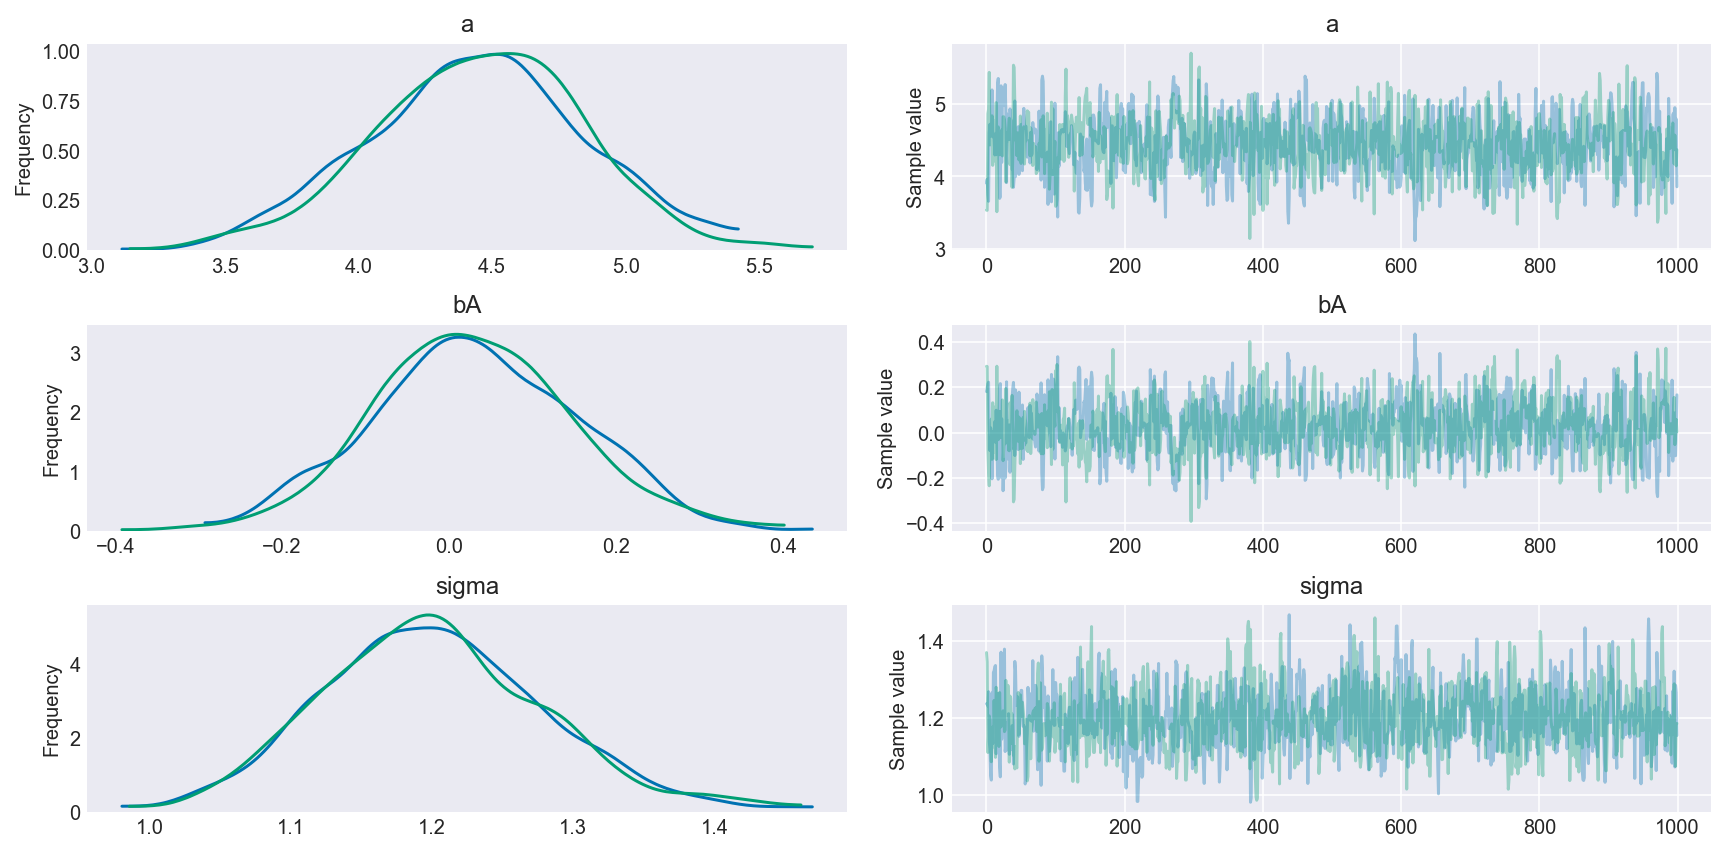

In [43]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace, varnames);

In [44]:
pm.summary(trace, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      4.441  0.393     0.013    3.836     5.083  866.985   1.0
bA     0.028  0.119     0.004   -0.175     0.209  891.998   1.0
sigma  1.200  0.079     0.003    1.079     1.327  991.876   1.0

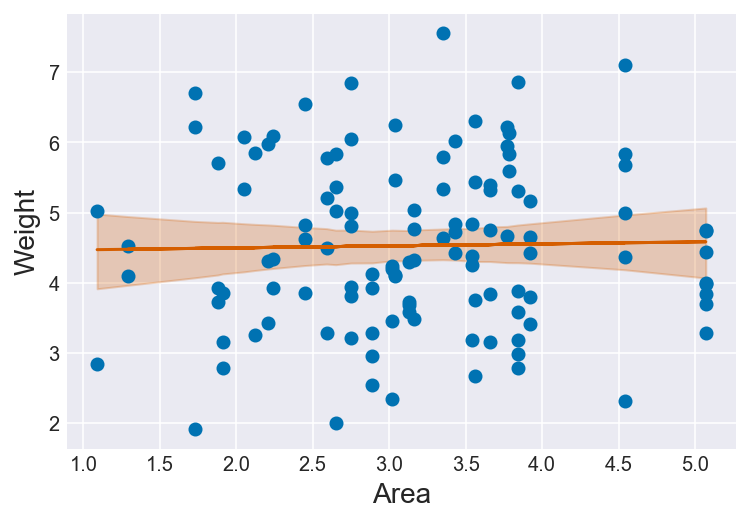

In [45]:
#plot results
mu_mean = trace['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(df.area, df.weight, 'C0o')
plt.plot(df.area, mu_mean.mean(0), 'C2')

idx = np.argsort(df.area)
plt.fill_between(df.area[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Area', fontsize=14)
plt.ylabel('Weight', fontsize=14);

## M2

In [68]:
df.groupsize.unique()

array([2, 3, 7, 4, 8, 5, 6], dtype=int64)

In [69]:
# Weifht as a function of area
with pm.Model() as m:
    a = pm.Normal('a', mu=0, sd=100)
    bB = pm.Normal('bB', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', a + bB * df.groupsize)
    W = pm.Normal('Weight', mu=mu, sd=sigma, observed=df.weight)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bB, a]


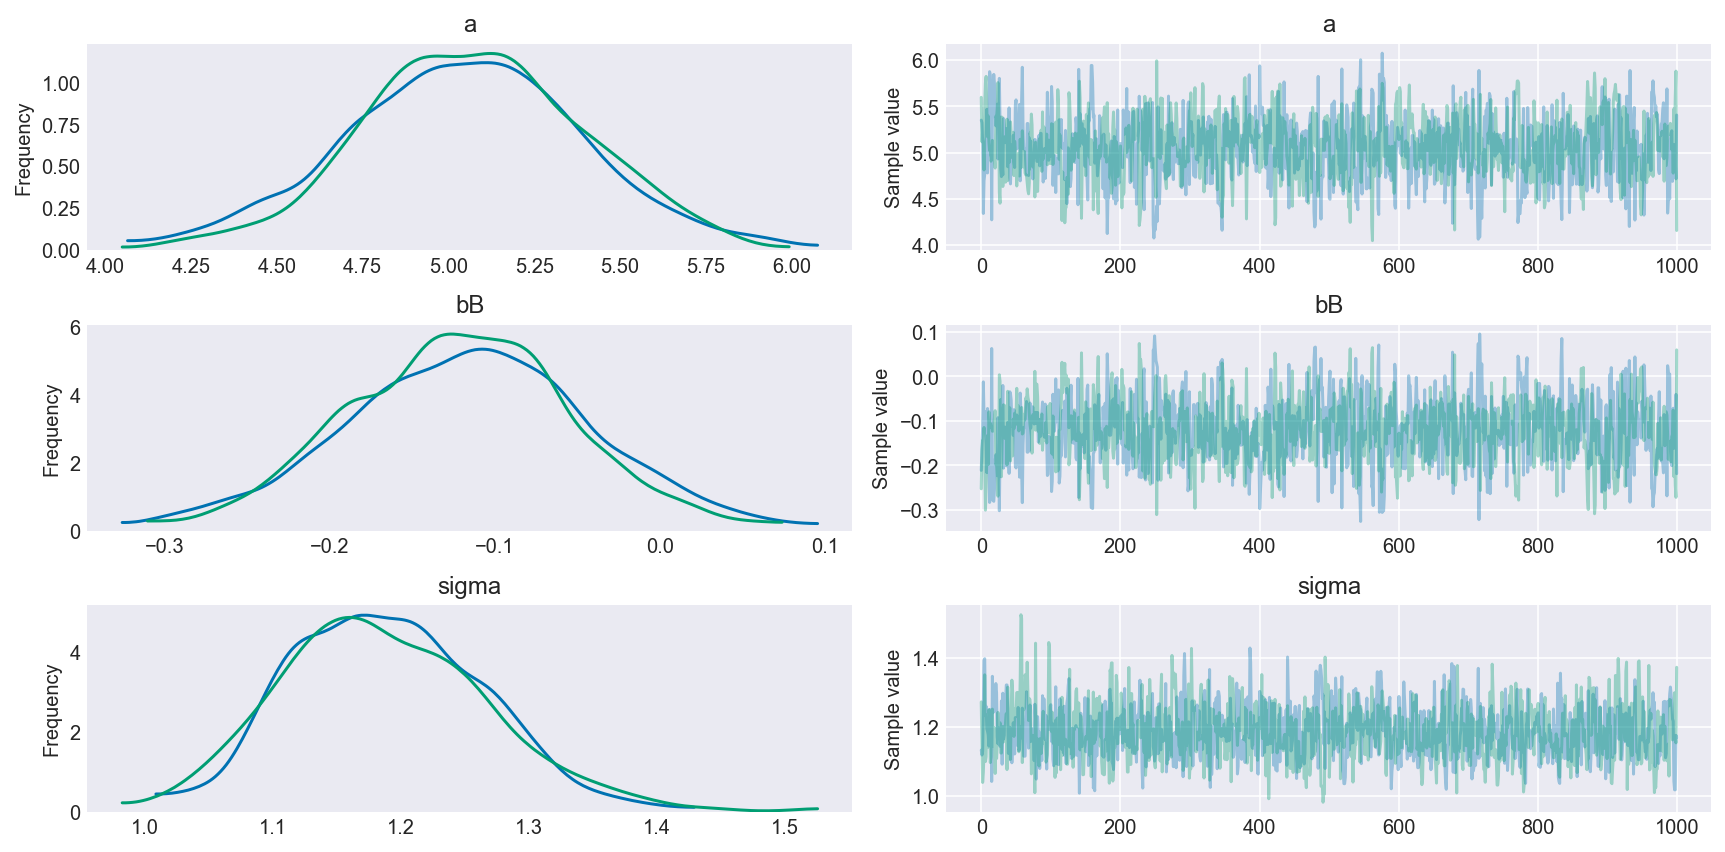

In [70]:
varnames = ['a', 'bB', 'sigma']
pm.traceplot(trace, varnames);

In [71]:
pm.summary(trace, varnames).round(3)

mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff   Rhat
a      5.052  0.333     0.012    4.381     5.703   768.558  1.001
bB    -0.120  0.071     0.002   -0.261     0.020   771.660  1.001
sigma  1.187  0.077     0.002    1.032     1.330  1068.054  1.000

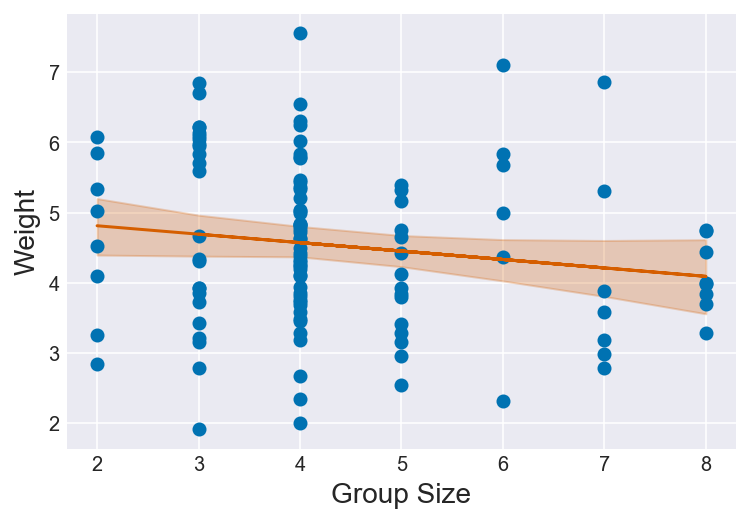

In [72]:
#plot results
mu_mean = trace['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(df.groupsize, df.weight, 'C0o')
plt.plot(df.groupsize, mu_mean.mean(0), 'C2')

idx = np.argsort(df.groupsize)
plt.fill_between(df.groupsize[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Group Size', fontsize=14)
plt.ylabel('Weight', fontsize=14);

Looks like area is not important, but groupsize is just about not important for the prediction of weight of the fox

# H2

Now fit a multiple linear regression with weight as the outcome and both area and groupsize
as predictor variables. Plot the predictions of the model for each predictor, holding the other predictor
constant at its mean. What does this model say about the importance of each variable? Why do you
get different results than you got in the exercise just above?

In [73]:
# Weifht as a function of area
with pm.Model() as m:
    a = pm.Normal('a', mu=0, sd=100)
    bC = pm.Normal('bC', mu=0, sd=10,shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', a + bC[0] * df.groupsize + bC[1] * df.area )
    W = pm.Normal('Weight', mu=mu, sd=sigma, observed=df.weight)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bC, a]


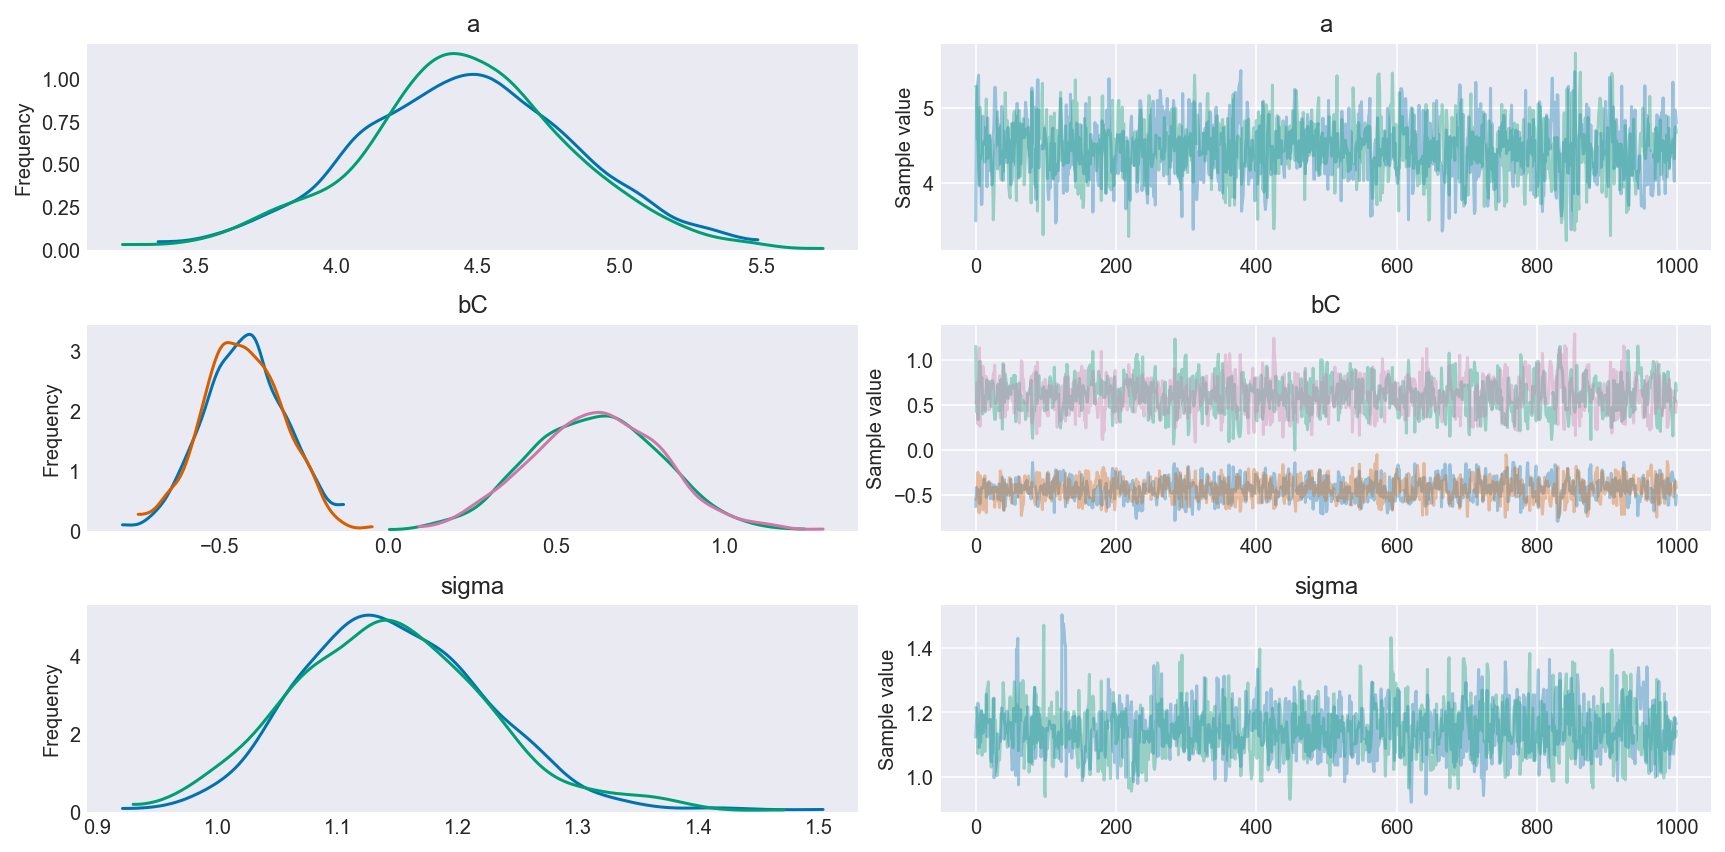

In [74]:
varnames = ['a', 'bC', 'sigma']
pm.traceplot(trace, varnames);

In [75]:
pm.summary(trace, varnames).round(3)

mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff  Rhat
a      4.452  0.379     0.010    3.698     5.203  1291.817   1.0
bC__0 -0.430  0.120     0.003   -0.666    -0.203  1177.033   1.0
bC__1  0.615  0.194     0.006    0.247     0.996  1123.335   1.0
sigma  1.145  0.080     0.002    0.986     1.297  1106.803   1.0

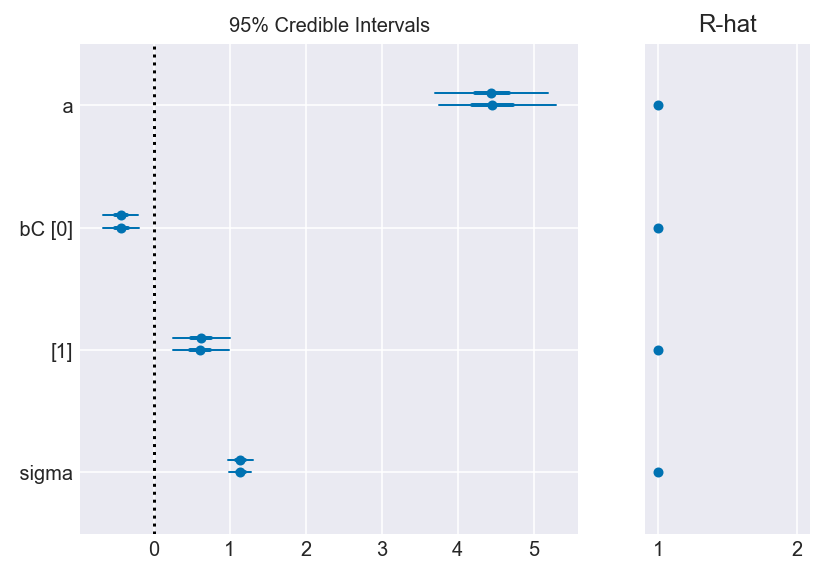

In [76]:
pm.forestplot(trace, varnames=varnames);

In [65]:
trace['a'].shape,trace['bC'].shape,trace['sigma'].shape,

((2000L,), (2000L, 2L), (2000L,))

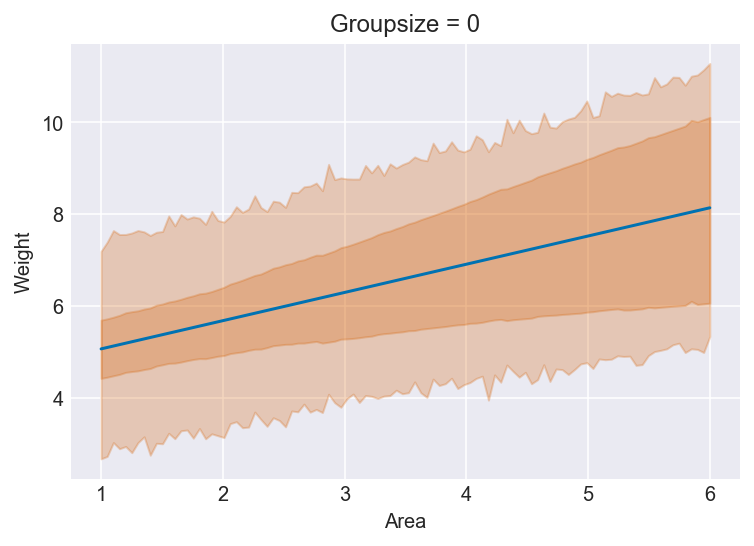

In [80]:
#Area
R_avg = np.linspace(1, 6, 100)

mu_pred = trace['a'] + trace['bC'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Area')
plt.ylabel('Weight')
plt.title('Groupsize = 0');

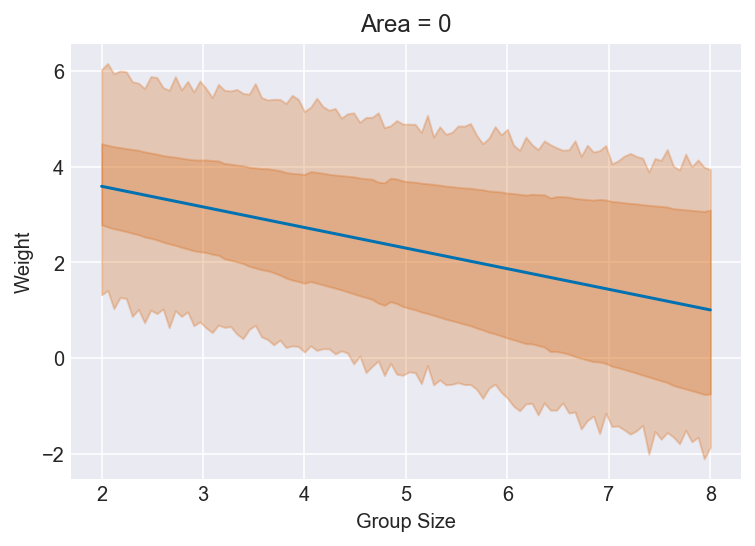

In [81]:
#Group Size
R_avg = np.linspace(2, 8, 100)

mu_pred = trace['a'] + trace['bC'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Group Size')
plt.ylabel('Weight')
plt.title('Area = 0');

During the linear regression we did not really see any correlation. But we do now. This is because the predictors are correlated with each other. Area positively as seen in the first plot and Groupsize negatively as seen in the second plot

Text(0,0.5,'Group Size')

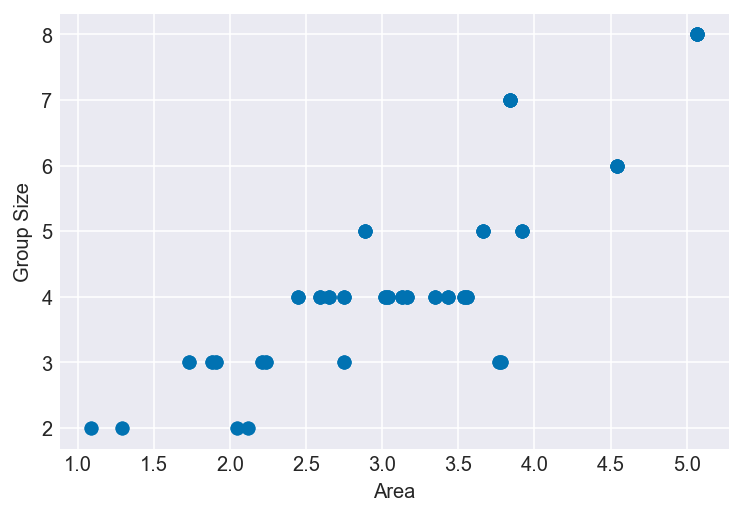

In [84]:
plt.scatter(df.area,df.groupsize)
plt.xlabel("Area")
plt.ylabel("Group Size")

# H3

Finally, consider the avgfood variable. Fit two more multiple regressions: (1) body weight
as an additive function of avgfood and groupsize, and (2) body weight as an additive function of
all three variables, avgfood and groupsize and area. Compare the results of these models to the
previous models youâ€™ve fit, in the first two exercises. (a) Is avgfood or area a better predictor of body
weight? If you had to choose one or the other to include in a model, which would it be? Support your
assessment with any tables or plots you choose. (b) When both avgfood or area are in the same
model, their effects are reduced (closer to zero) and their standard errors are larger than when they
are included in separate models. Can you explain this result?

## M31

In [15]:
# Weifht as a function of area
with pm.Model() as m:
    a = pm.Normal('a', mu=0, sd=100)
    bD = pm.Normal('bD', mu=0, sd=1,shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', a + bD[0] * df.groupsize + bD[1] * df.avgfood )
    W = pm.Normal('Weight', mu=mu, sd=sigma, observed=df.weight)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bD, a]
The acceptance probability does not match the target. It is 0.8803320432493411, but should be close to 0.8. Try to increase the number of tuning steps.


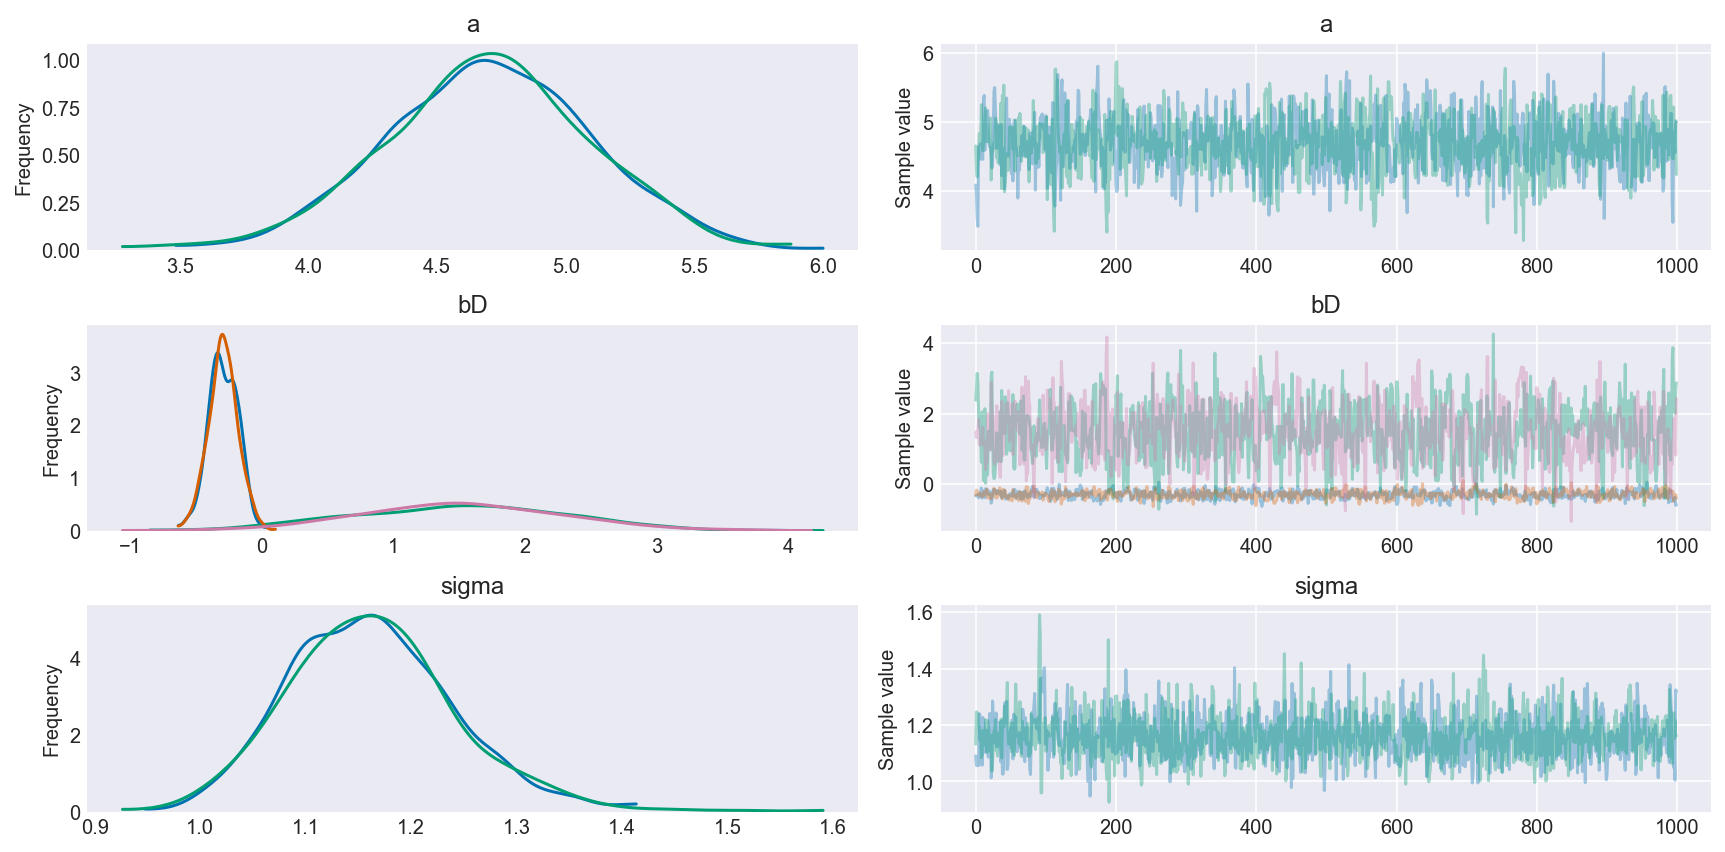

In [16]:
varnames = ['a', 'bD', 'sigma']
pm.traceplot(trace, varnames);

In [17]:
pm.summary(trace, varnames).round(3)

mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff  Rhat
a      4.693  0.397     0.011    3.926     5.457  1256.943   1.0
bD__0 -0.297  0.112     0.004   -0.507    -0.076   833.164   1.0
bD__1  1.493  0.792     0.026    0.038     3.065   832.495   1.0
sigma  1.161  0.078     0.002    1.015     1.319  1305.231   1.0

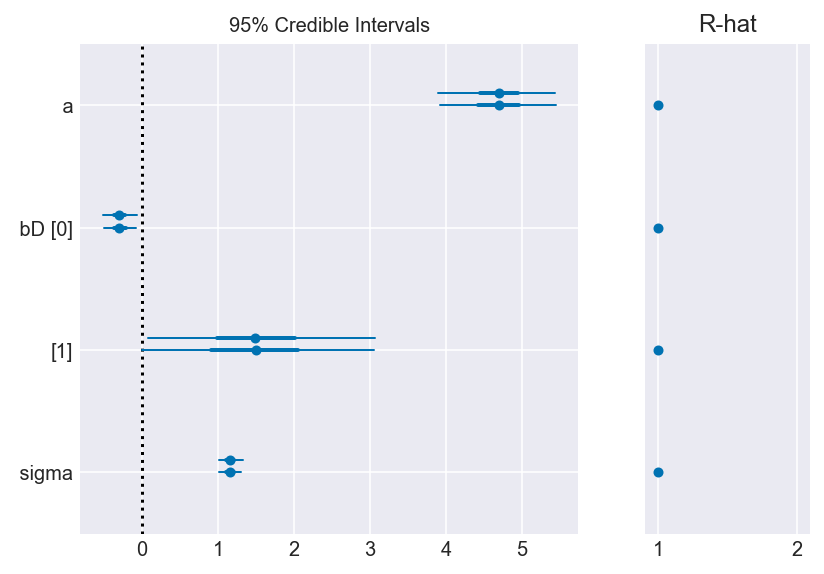

In [18]:
pm.forestplot(trace, varnames=varnames);

In [19]:
df.max()

group        30.00
avgfood       1.21
groupsize     8.00
area          5.07
weight        7.55
dtype: float64

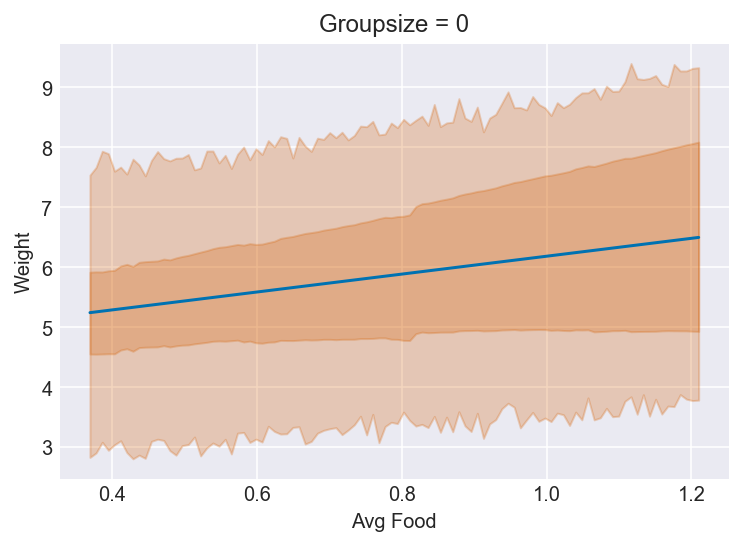

In [22]:
#Area
R_avg = np.linspace(min(df.avgfood), max(df.avgfood), 100)

mu_pred = trace['a'] + trace['bD'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Avg Food')
plt.ylabel('Weight')
plt.title('Groupsize = 0');

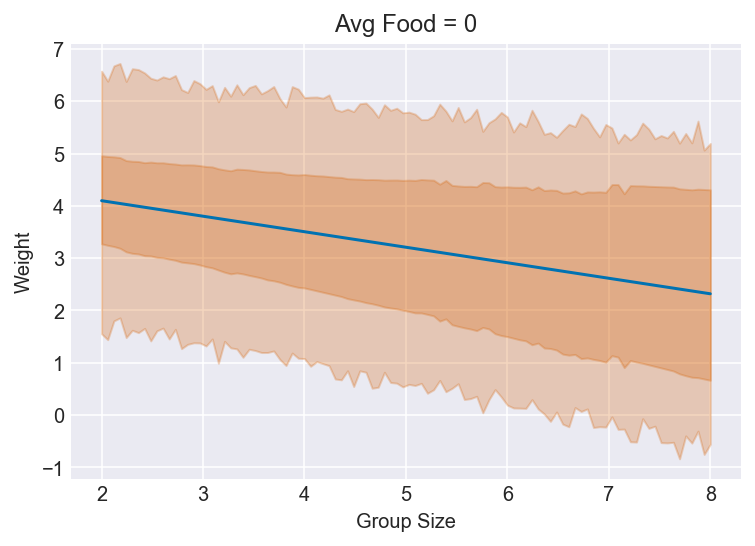

In [24]:
#Group Size
R_avg = np.linspace(2, 8, 100)

mu_pred = trace['a'] + trace['bD'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Group Size')
plt.ylabel('Weight')
plt.title('Avg Food = 0');

## M32

In [4]:
# Weifht as a function of area
with pm.Model() as m:
    a = pm.Normal('a', mu=0, sd=100)
    bE = pm.Normal('bE', mu=0, sd=10,shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', a + bE[0] * df.groupsize + bE[1] * df.avgfood + bE[2] * df.area  )
    W = pm.Normal('Weight', mu=mu, sd=sigma, observed=df.weight)
    trace = pm.sample(1000, tune=1000)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '1248' (I am process '14024')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bE, a]


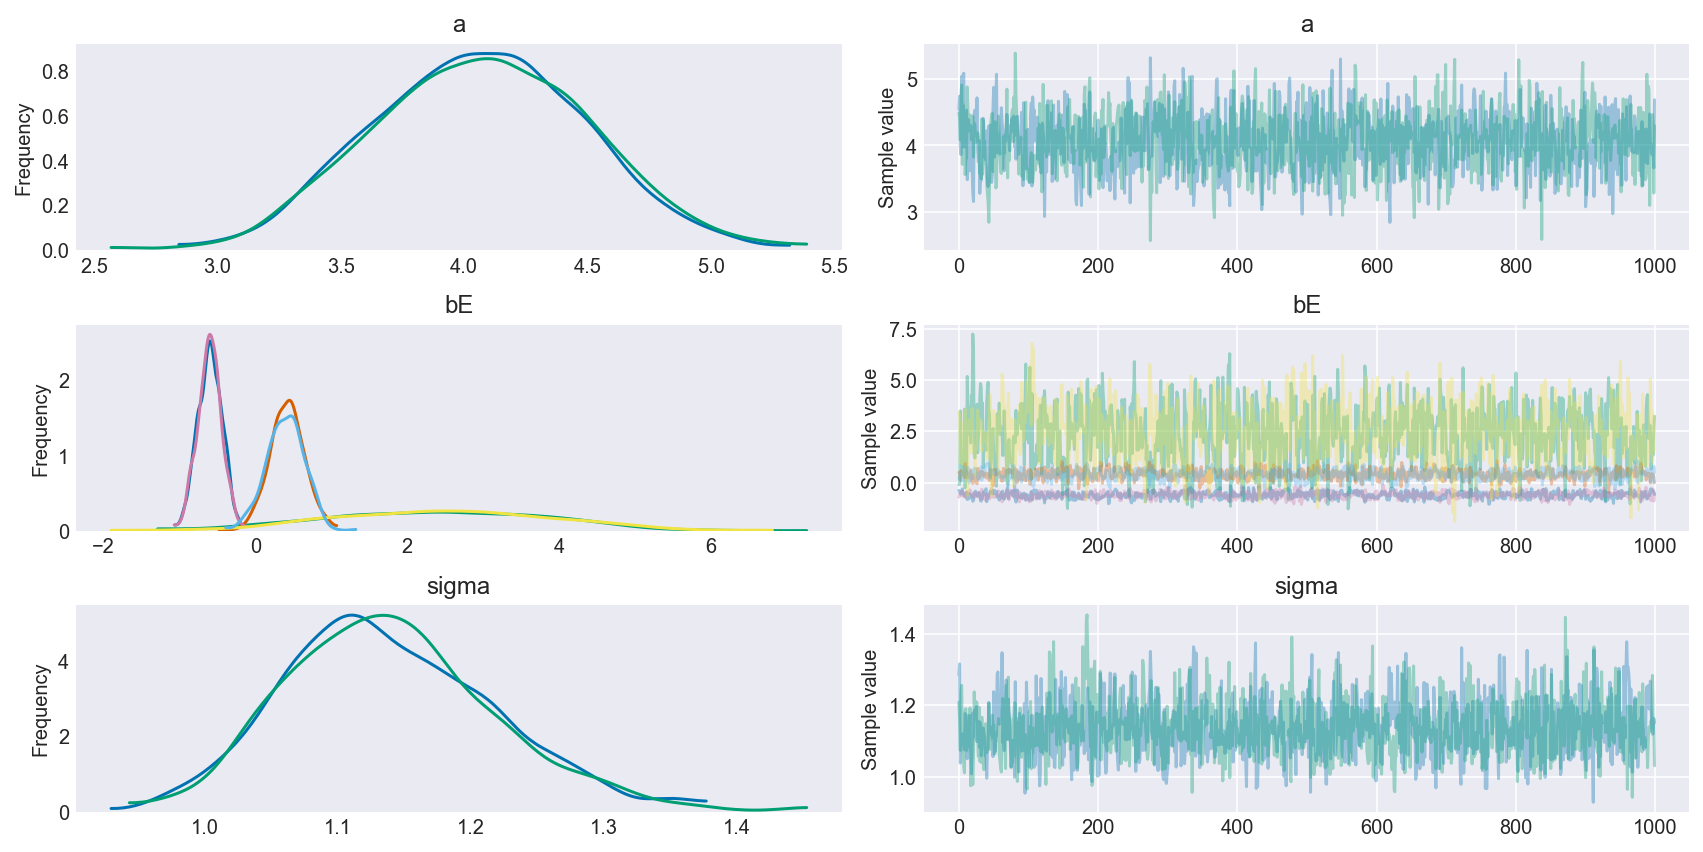

In [5]:
varnames = ['a', 'bE', 'sigma']
pm.traceplot(trace, varnames);

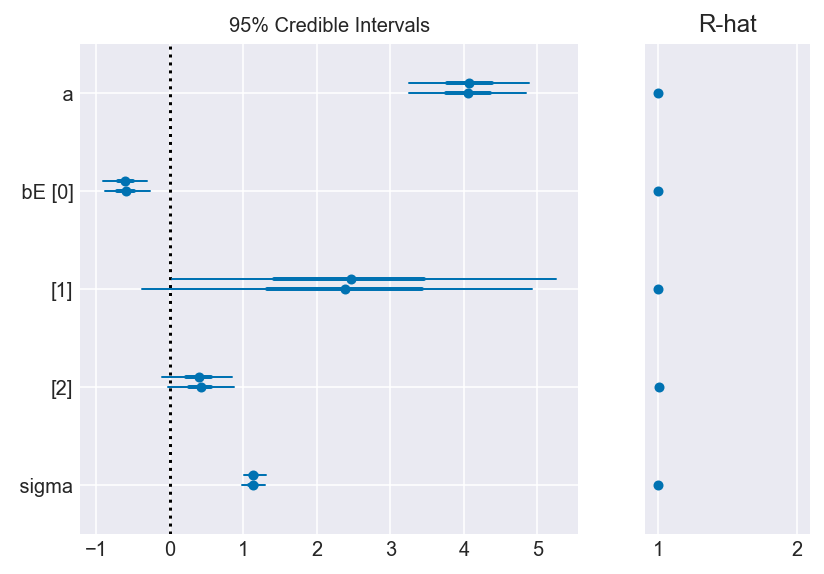

In [6]:
pm.forestplot(trace, varnames=varnames);

In [14]:
pm.summary(trace, varnames).round(3)

mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff   Rhat
a      4.061  0.430     0.012    3.248     4.874  1317.819  1.000
bE__0 -0.603  0.157     0.005   -0.902    -0.297  1141.372  1.000
bE__1  2.415  1.429     0.045   -0.196     5.142   882.459  1.001
bE__2  0.403  0.238     0.008   -0.074     0.860   927.520  1.002
sigma  1.138  0.078     0.002    1.004     1.307  1142.819  1.000

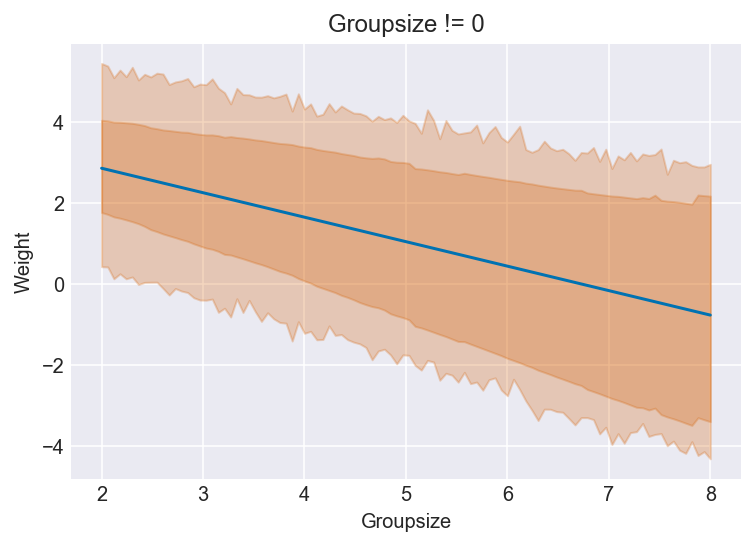

In [10]:
#Area

R_avg = np.linspace(2, 8, 100)

mu_pred = trace['a'] + trace['bE'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Groupsize')
plt.ylabel('Weight')
plt.title('Groupsize != 0');

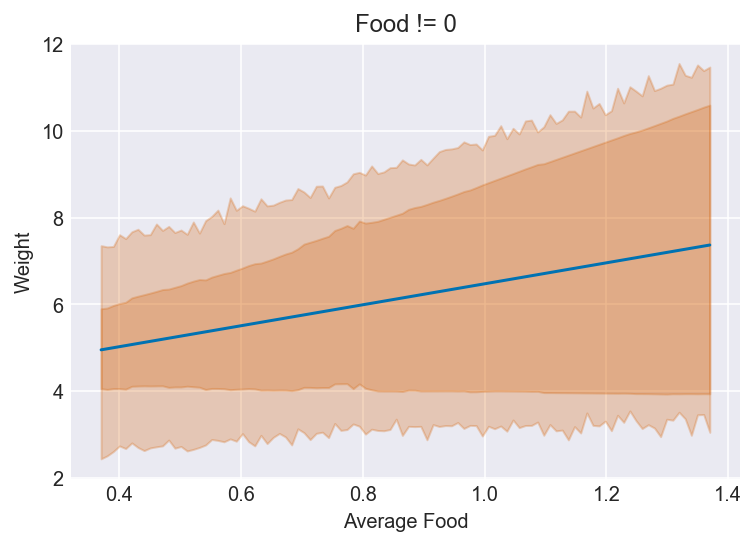

In [11]:
#Group Size
R_avg = np.linspace(0.37, 1.37, 100)

mu_pred = trace['a'] + trace['bE'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Average Food')
plt.ylabel('Weight')
plt.title('Food != 0');

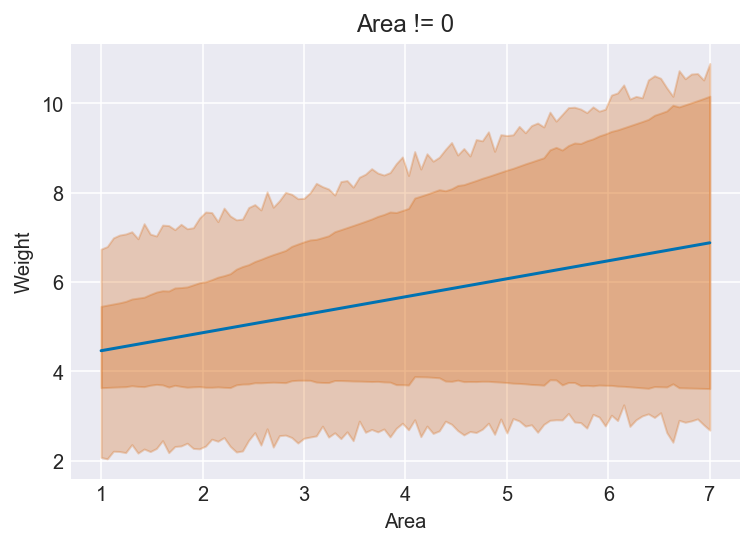

In [13]:
#Group Size

R_avg = np.linspace(1, 7, 100)

mu_pred = trace['a'] + trace['bE'][:,2] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Area')
plt.ylabel('Weight')
plt.title('Area != 0');

STD of the coef of averageFood is too high. Even thougbt the value of the predictor is higher, I am inclined to say that I like Area more. I would include Area. Also compare H2 vs H31, the model with just groupsize and area does fairly well.

They are both similarly correalted (so multicollinearity). Hence putting them together with groupsize can have an effect of including the same information. However, this can reduce SE.